<h1>制御対象の振舞い</h1>

Pythonによる制御工学入門 P94~  


<h2>時間応答</h2>

まずは代表的なシステムである１次遅れ系（First-Order Lag System）と２次遅れ系（Second-Order Lag System）を見ていきます。  

加えて、ステップ上の入力を加えたときの出力の振舞いである **ステップ応答 (Step Response)**を見ていきます。  

ステップ応答は以下の式の通りに定義されます。  

```math
u(t) = \left\{
    \begin{array}{ll}
        1 & (t \geq 0) \\
        0 & (t \lt 0)
    \end{array}
\right.
```

Pythonの```control```モジュールでは、ステップ応答は```y, t = step(sys, Td)```で計算できます。

<h3>１次遅れ系 First-Order Lag System</h3>

このノートブックで使う例として、台車の伝達関数モデルを使います。  

```math
P(s) = \frac{1}{Ms + \mu} = \frac{\frac{1}{\mu}}{1 + \frac{M}{\mu}s}
```

１次遅れ系には$K$をゲイン、$T$を時定数のパラメータを持ち、上記の台車系の伝達関数モデルに対して$K=\frac{1}{\mu}$、$T=\frac{M}{\mu}$と置くと、台車系の伝達関数モデルを適用した１次遅れ系は以下のように定義できます。  

```math
P(s) = \frac{K}{1+Ts}
```

上記の式を早速計算させてみます。

In [1]:
def steady_value(t: float, ts: list, y: list) -> float:
    for i, ti in enumerate(ts):
        if t == ti:
            return y[i]

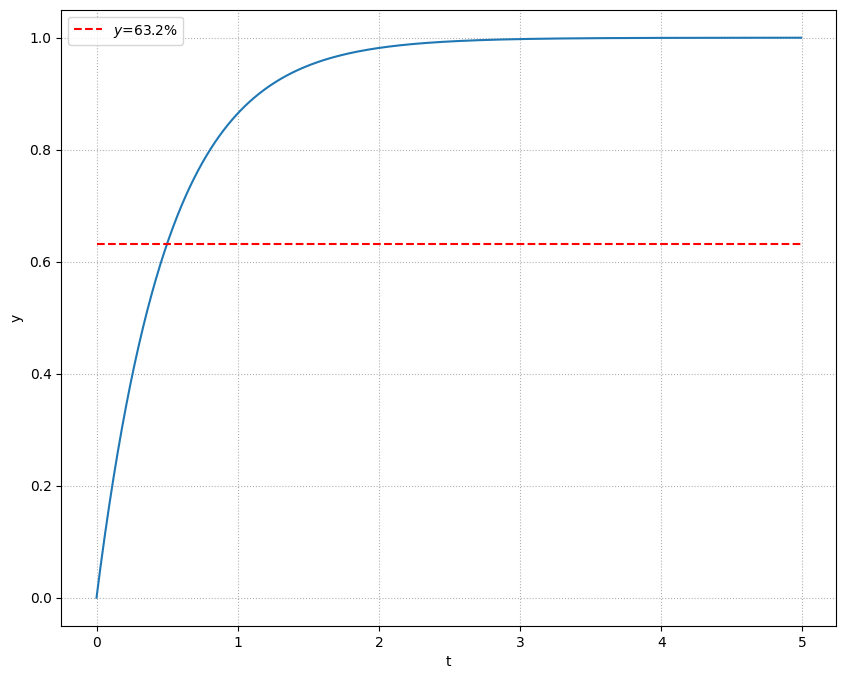

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from control.matlab import tf, step
from control.matlab import TransferFunction

from plot import plot_set

# Define the transfer function for the system
T, K = 0.5, 1
P = tf([0, K], [T, 1])
y, t = step(P, np.arange(0, 5, 0.01))
v = steady_value(T, t, y)

fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(t, y)
ax.plot(t, np.full(len(t), v), 'r--', label=f'$y$={v*100:.1f}%')
ax.legend()
plot_set(ax, 't', 'y')

上記の１次遅れ系で$T=0.5$、$K=1$だった時の場合の定常値（時間が十分経過したときの値）$y$は63.2%ととなります。言い換えると、出力の定常値の63.2%に到達する時間の時定数が$T=0.5$と表現できます。  

$T$は速応性（応答の速度）を決定するパラメータになりますので、中々良い数字のように思えます。  

もし、時定数$T$を徐々に下げていくとどうなるでしょうか？

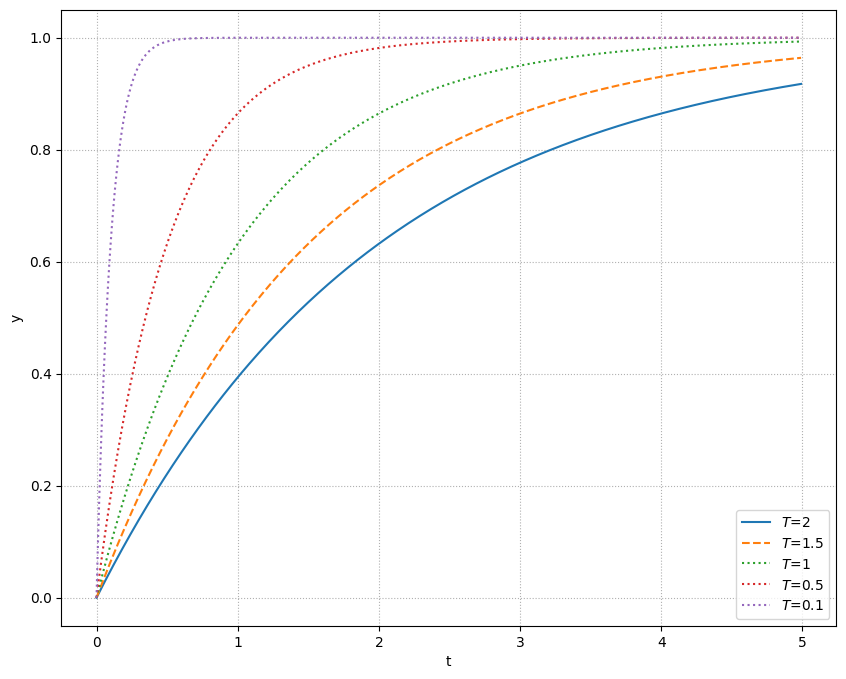

In [3]:
from plot import linestype_generator

# define the calculation of y and t, steady values.
def first_order_lag_system(K: float, T: list[float]) -> list:
    res = []
    for ts in T:
        P = tf([0, K], [ts, 1])
        y, t = step(P, np.arange(0, 5, 0.01))
        res.append((y, t))
    return res

# let's calculation!
LS = linestype_generator()
fig, ax = plt.subplots(figsize=(10, 8))

K = 1
T = [2, 1.5, 1, 0.5, 0.1]

ys = first_order_lag_system(K, T)

for ts, (y, t) in zip(T, ys):
    ax.plot(t, y, ls=next(LS), label=f'$T$={ts}')
    ax.legend()

plot_set(ax, 't', 'y')

パラメータ$T$を大きくすれば応答は遅くなり、小さくすれば応答は早くなりそうな予感がします。そして、その予測は上記の図を見る限りでは当たっているように思われます。  

反対に、$T=-1$の時はどうなるでしょうか？

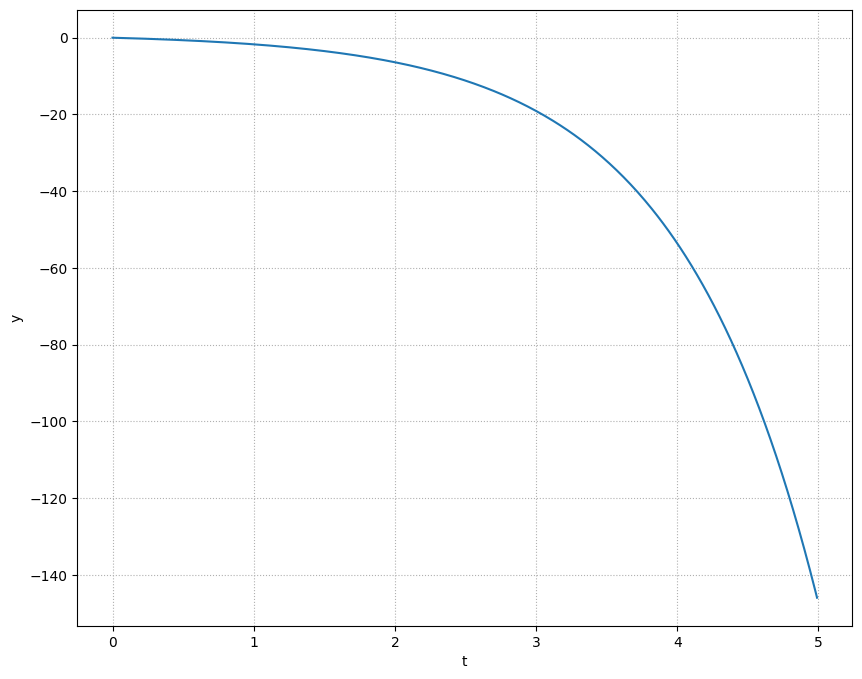

In [4]:
K = 1
T = -1

P = tf([0, K], [T, 1])
y, t = step(P, np.arange(0, 5, 0.01))

fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(t, y)
plot_set(ax, 't', 'y')

$T$が負数のとき、一定値には収束せず発散し、出力値$y$は-140以上まで下がることがわかります。  

パラメータ$K$を変化させたとき、どうなるでしょうか？合わせて、$K$を変化させると定常値も変わるため、定常値がどうなるかも合わせて確認してみます。

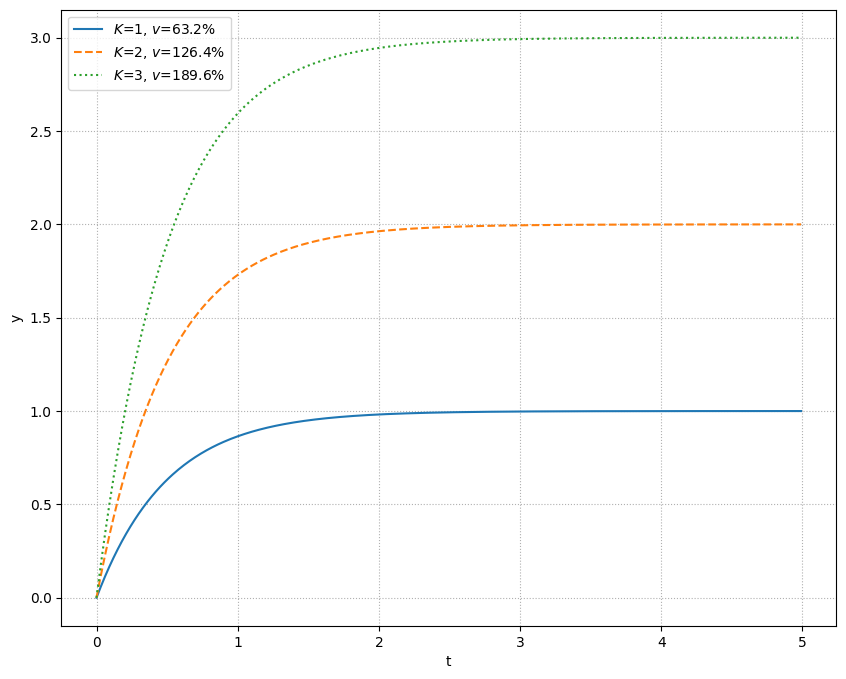

In [5]:
LS = linestype_generator()
fig, ax = plt.subplots(figsize=(10, 8))

def first_order_lag_system(K: list[float], T: float) -> list:
    res = []
    for Ki in K:
        P = tf([0, Ki], [T, 1])
        y, t = step(P, np.arange(0, 5, 0.01))
        v = steady_value(T, t, y)
        res.append((y, t, v))
    return res

K = [1, 2, 3]
T = 0.5

ys = first_order_lag_system(K, T)

for Ki, (y, t, v) in zip(K, ys):
    ax.plot(t, y, ls=next(LS), label=f'$K$={Ki}, $v$={v*100:.1f}%')
    ax.legend()

plot_set(ax, 't', 'y')

パラメータ$K$を大きくすると、定常値$y$も大きくなります。このことから、定常値が$y(\infty)=K$になることが分かります。

台車のモデルと上の１次遅れ系とを紐づけてみると、車輪を動かすモータに一定の電圧を印加すると台車は動き出し、一定の速度で走り続けるようになります。  

台車の質量が小さければ、動き始めから等速になるまでの間が短くなり速度も早くなります。反対に台車の質量が大きければ、動き始めから等速までの間が長くなり、速度も小さいものになります。これは$T=\frac{M}{\mu}$と$K=\frac{1}{\mu}$、粘性摩擦との関連から、直観的に理解可能です。  

<h3>2次遅れ系 Second-Order Lag System</h3>

2次遅れ系に適用するのはRLC回路の伝達関数モデルになります。  

```math
P(s) = \frac{1}{CLs^2+CRs+1} = \frac{\frac{1}{CL}}{s^2+\frac{R}{L}s+\frac{1}{CL}}
```

パラメータ$K=1$、$\omega_n=\sqrt{\frac{1}{CL}}$、$\varsigma=\frac{R}{2}\sqrt{\frac{C}{L}}=\frac{R}{2L\omega_n}$として、  

```math
P(S) = \frac{K\omega^2_n}{s^2+2\varsigma\omega_n s+\omega^2_n}
```

と表現します。ここで、パラメータ$\varsigma$は減衰係数、$\omega_n$は固有角周波数と呼びます。この系のステップ応答を見ていきます。

In [6]:
def overshoot(y: list, t: list) -> tuple:
    y_max = np.max(y)
    tp = t[np.argmax(y)]
    return y_max, tp

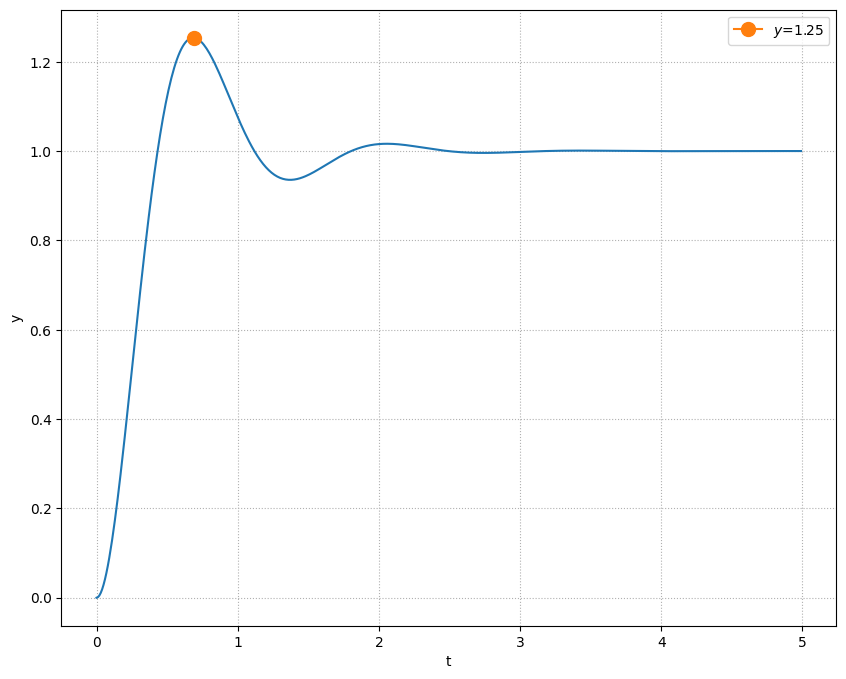

In [7]:
zeta, omega_n = 0.4, 5

# Step Responce of Second-Order Lag System.
P = tf([omega_n**2], [1, 2*zeta*omega_n, omega_n**2])
y, t = step(P, np.arange(0, 5, 0.01))
y_max, tp = overshoot(y, t)

fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(t, y)
ax.plot(tp, y_max, marker='.', markersize=20, label=f'$y$={np.max(y):.2f}')
ax.legend()
plot_set(ax, 't', 'y')

$Tp=0.685$秒あたりで$y_{max}=1.25$の値を取っています。このことを最大行き過ぎ量（Overshoot）と言います。このオーバーシュートは1次遅れ系では発生しません。  

$\varsigma=1, 0.7, 0.4$と、減衰係数を変化させていった時の変化を見ていきます。

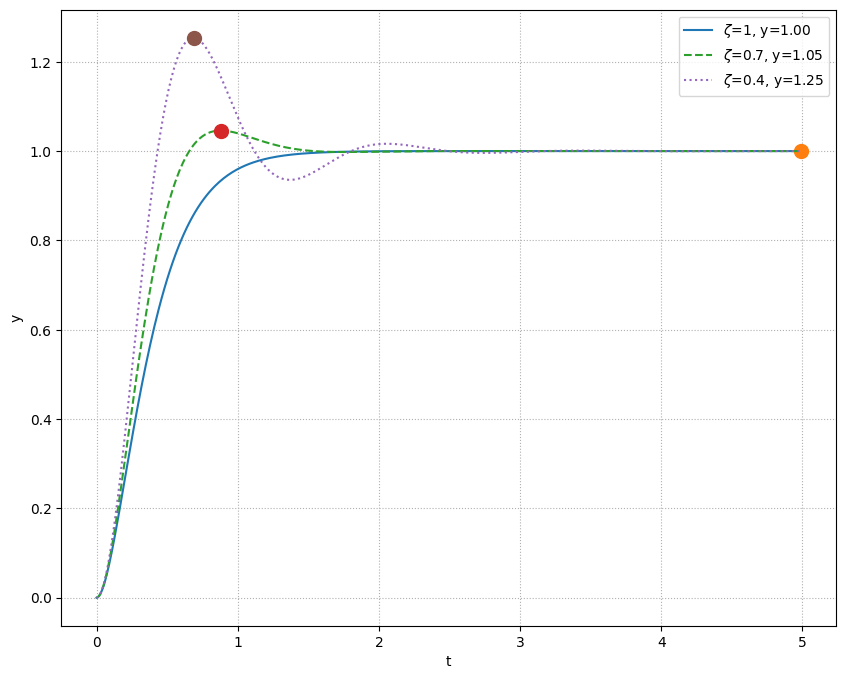

In [8]:
LS = linestype_generator()
fig, ax = plt.subplots(figsize=(10, 8))

zeta = [1, 0.7, 0.4]
omega_n = 5
for z in zeta:
    P = tf([0, omega_n**2], [1, 2*z*omega_n, omega_n**2])
    y, t = step(P, np.arange(0, 5, 0.01))
    y_max, tp = overshoot(y, t)

    pltargs = {'ls': next(LS), 'label': f'$\\zeta$={z}, y={y_max:.2f}'}
    ax.plot(t, y, **pltargs)
    ax.plot(tp, y_max, marker='.', markersize=20)

plot_set(ax, 't', 'y', 'best')

さらに$\varsigma=0.1, 0, -0.05$としたときの結果を考えます。

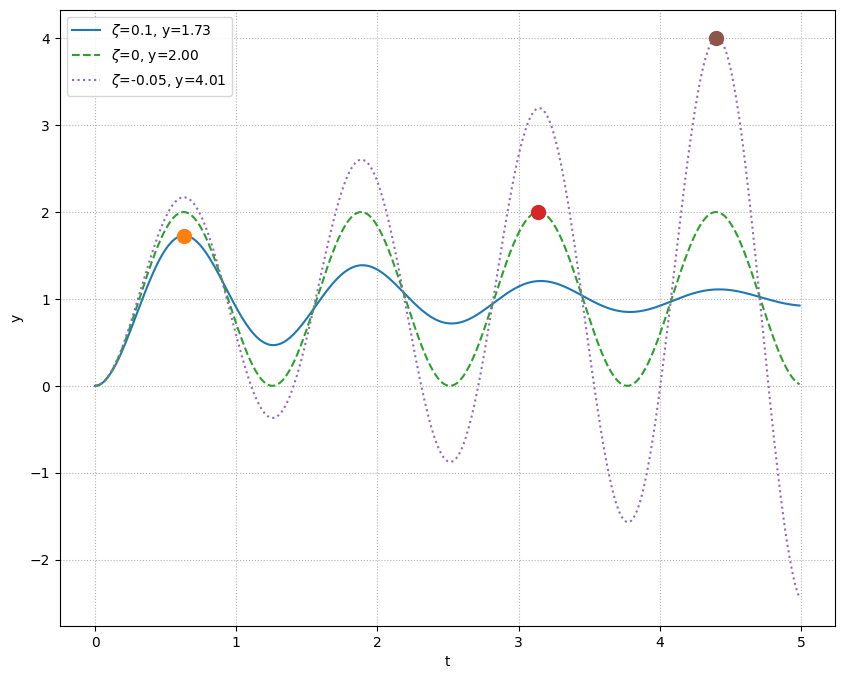

In [9]:
LS = linestype_generator()
fig, ax = plt.subplots(figsize=(10, 8))

zeta = [0.1, 0, -0.05]
omega_n = 5
for z in zeta:
    P = tf([0, omega_n**2], [1, 2*z*omega_n, omega_n**2])
    y, t = step(P, np.arange(0, 5, 0.01))
    y_max, tp = overshoot(y, t)

    pltargs = {'ls': next(LS), 'label': f'$\\zeta$={z}, y={y_max:.2f}'}
    ax.plot(t, y, **pltargs)
    ax.plot(tp, y_max, marker='.', markersize=20)

plot_set(ax, 't', 'y', 'best')

減衰係数が$1.0$または$0.1$であれば$1$に収束していきますが、徐々に下げていくと最大行き過ぎ量は増加し、最終的に振動が発散していることが分かります（$\varsigma=-0.05$の例）  
このことから、減衰係数$\varsigma$は減衰性（安定度）を決めるパラメータと言えます。　　

次は固有角周波数$\omega_n=1, 5, 1.0$と変化させてみます。

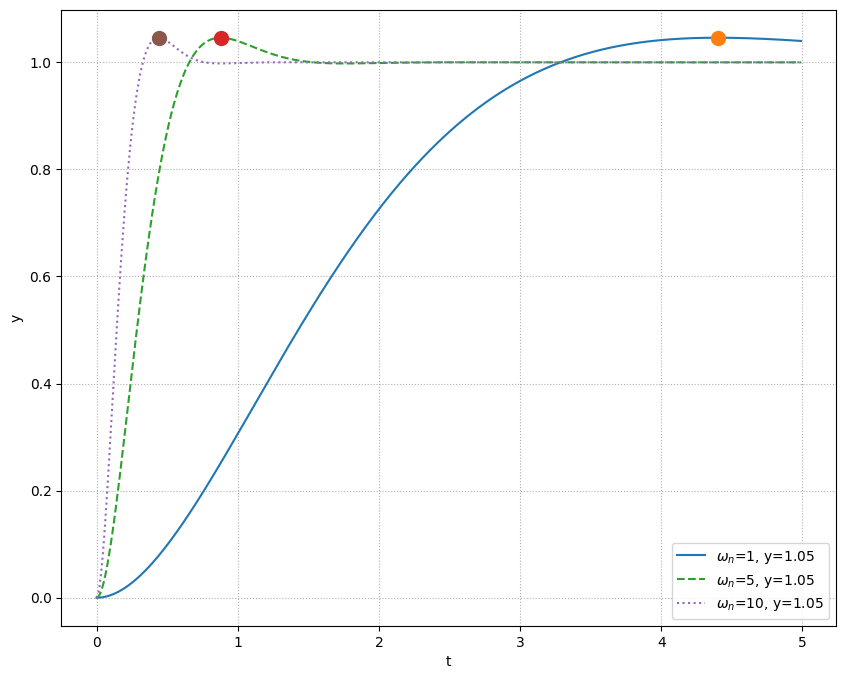

In [10]:
LS = linestype_generator()
fig, ax = plt.subplots(figsize=(10, 8))

zeta = 0.7
omega_n = [1, 5, 10]
for omega_ni in omega_n:
    P = tf([0, omega_ni**2], [1, 2*zeta*omega_ni, omega_ni**2])
    y, t = step(P, np.arange(0, 5, 0.01))
    y_max, tp = overshoot(y, t)

    pltargs = {'ls': next(LS), 'label': f'$\\omega_n$={omega_ni}, y={y_max:.2f}'}
    ax.plot(t, y, **pltargs)
    ax.plot(tp, y_max, marker='.', markersize=20)

plot_set(ax, 't', 'y', 'best')

1次遅れ系のゲイン$K$と同じように、$\varsigma$を大きくすると応答が早くなることがわかり、最大行き過ぎ量は変わらないことが分かります。  

この結果も、台車系と同じようにRLC回路を紐づけて見ていくと、回路に電圧を印加すると回路に流れるキャパシタに電荷が溜まっていきます。そして徐々に電流が流れなくなりいずれキャパシタ両端の電圧は$1$に収束します。これが、2次遅れ系における固有角周波数$\omega_n$に対応付けられます。  

しかし、回路中にコイルがある場合、電流の増加や現象を妨げる方向に起電力を生じ、このコイルのインダクタンスが大きいほど強くなります（電磁誘導）。これにより、キャパシタ両端の電圧の増加が遅れたり、はたまた電圧が一時的に定常値の$1$を超えたりします。これをオーバーシュートの発生と見なせます。これが減衰係数$\varsigma$と対応付けられます。  

実際、前者は以下の式より、$L$が大きくなるほど出力される$\omega_n$は小さくなり、その逆も然りです。  

```math
\omega_n=\frac{1}{\sqrt{CL}}
```

後者の場合、$L$が大きくなるほど$\varsigma$は$0$に漸近し、応答に振動が発生します。  

```math
\varsigma=\frac{R\sqrt{C}}{2\sqrt{L}}
```

<h3>まとめ</h3>

- 1次遅れ系、2次遅れ系もステップ応答でその系の振舞いを見ることができる。
- 高次遅れ系がほとんどだが、1, 2次遅れ系まで最適化することができる。
- 1次遅れ系のパラメータはゲイン$K$と時定数$T$。時定数$T$はシステムの速応性を決定する。
- 2次遅れ系のパラメータはゲイン$K$と減衰係数$\varsigma$、固有角周波数$\omega_n$で、$\varsigma$は安定度、$\omega_n$は応答速度を決める。
- 1次遅れ系では時定数が$T<0$の時に発散し、2次遅れ系では減衰係数が$\varsigma \approx 0$のときに発散する。
- 1次遅れ系ではオーバーシュートは発生しないが、2次遅れ系では減衰係数$\varsigma$によっては発生する。

<h2>練習問題</h2>

以下の二つの伝達関数のステップ応答を確認します。  
一旦、伝達関数をステップ応答の関数に放り投げてみる。値を変更できるようにするにはもう少しかかりそう。

```math
P(s) = \frac{s + 3}{(s + 1)(s + 2)} \
=\frac{s + 3}{s^2 + 3s + 2}
```

/home/suitai/workspace/Python/venv/lib/python3.12/site-packages/plot.py:50: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  fig_ax.legend(loc=args[2])


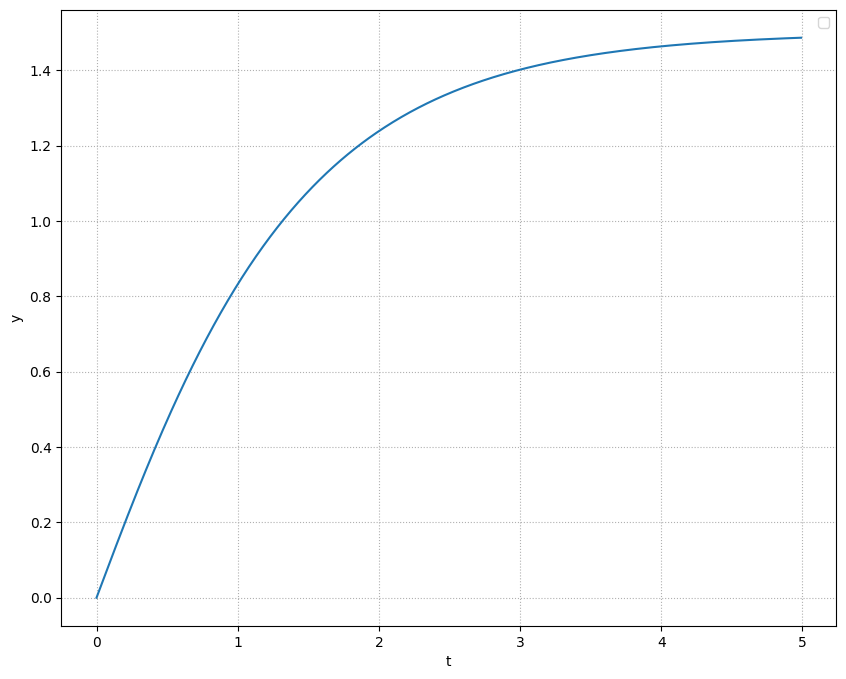

In [13]:
P = tf([1, 3], [1, 3, 2])
y, t = step(P, np.arange(0, 5, 0.01))

fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(t, y)

plot_set(ax, 't', 'y', 'best')

```math
P(s) = \frac{1}{s^3 + 2s^2 + 2s + 1}
```

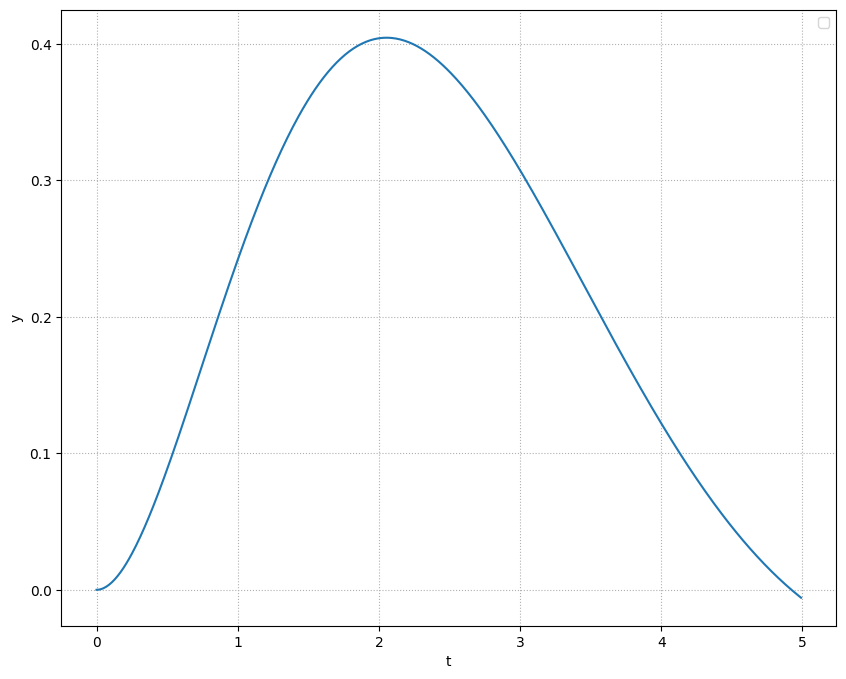

In [14]:
P = tf([1, 0], [1, 2, 2, 1])
y, t = step(P, np.arange(0, 5, 0.01))

fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(t, y)

plot_set(ax, 't', 'y', 'best')